In [0]:
# Import Packages
import os
!pip install pyspark
!pip install surprise
import surprise
from surprise import KNNWithMeans
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD
from scipy.sparse import csr_matrix
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
!pip install mxnet
import matplotlib.pyplot as plt
import mxnet
from mxnet import gluon
!pip install d2l
import d2l
from d2l import mxnet as d2l
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q  https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import *

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
tar: spark-3.2.0-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
spark = SparkSession \
        .builder \
        .master("local[*]") \
        .appName("Collaborative Filtering with MovieLens 100k") \
        .getOrCreate()
sc = spark.sparkContext
spark1 = SQLContext(sc)


/databricks/spark/python/pyspark/sql/context.py:82: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
#In this project, the experiments are on two datasets consisting data collected from actual social networks such as MovieLens-100k and Netflix 13M.

In [0]:
#@save
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'movie_id', 'ratings', 'timestamp']
    movies = ['titles']
    df = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    df_movies = pd.read_csv(os.path.join(data_dir, 'u.item'), '\t', names=movies,
                       engine='python')
    n_users = df.user_id.unique().shape[0]
    n_items = df.movie_id.unique().shape[0]
    return df, n_users, n_items, df_movies

In [0]:
df, n_users, n_items, df_movies = read_data_ml100k()

In [0]:
# Sparsity of rating matrix
sparsity = len(df) / (n_users * n_items)
print(f'matrix sparsity for movielens-100k: {sparsity:f}')

matrix sparsity for movielens-100k: 0.063047


In [0]:
movie_id = df_movies['titles'].str.split("|",n=1,expand=True)
# print(movie_id[0])
df_movies['movie_id']=movie_id[0]
title = movie_id[1].str.split("|",n=1,expand=True)
title_without_year = title[0].str.split("(",n=1,expand=True)
title_refine = title_without_year[0].str.strip()
df_movies['title'] =title_refine
df_movies.drop(columns=['titles'],inplace=True)
df_movies['movie_id']=df_movies['movie_id'].astype(str).astype(int)
df['movie_id']=df['movie_id'].astype(str).astype(int)
df['user_id']=df['user_id'].astype(str).astype(int)
df = df.merge(df_movies,on='movie_id')

In [0]:
df.head()

user_id 
 movie_id 
 ratings 
 timestamp 
 title 
 
 
 
 
 0 
 196 
 242 
 3 
 881250949 
 Kolya 
 
 
 1 
 63 
 242 
 3 
 875747190 
 Kolya 
 
 
 2 
 226 
 242 
 5 
 883888671 
 Kolya 
 
 
 3 
 154 
 242 
 3 
 879138235 
 Kolya 
 
 
 4 
 306 
 242 
 5 
 876503793 
 Kolya

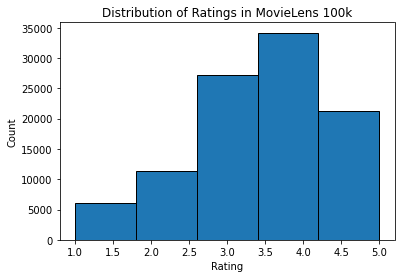

In [0]:
d2l.plt.hist(df['ratings'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100k')
d2l.plt.show()

In [0]:
#To make things easier to understand and work with, we are creating a table that will represents ratings for each user and movie pair.

mat = df.pivot(index='movie_id', columns='user_id', values='ratings')
print('The User-Movie Matrix')
mat.head(10)

The User-Movie Matrix


user_id 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 ... 
 934 
 935 
 936 
 937 
 938 
 939 
 940 
 941 
 942 
 943 
 
 
 movie_id 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 5.0 
 4.0 
 NaN 
 NaN 
 4.0 
 4.0 
 NaN 
 NaN 
 NaN 
 4.0 
 ... 
 2.0 
 3.0 
 4.0 
 NaN 
 4.0 
 NaN 
 NaN 
 5.0 
 NaN 
 NaN 
 
 
 2 
 3.0 
 NaN 
 NaN 
 NaN 
 3.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 4.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 5.0 
 
 
 3 
 4.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 4.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 4 
 3.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 5.0 
 NaN 
 NaN 
 4.0 
 ... 
 5.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 2.0 
 NaN 
 NaN 
 NaN 
 
 
 5 
 3.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 6 
 5.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 5.0 
 NaN 
 ... 
 NaN 
 NaN 
 5.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 7 
 4.0 
 NaN 
 NaN 
 NaN 
 NaN 
 2.0 
 5.0 
 3.0 
 4.0 
 4.0 
 ... 
 NaN 
 NaN 
 4.0 
 NaN 
 4.0 
 NaN 
 4.0 
 4.0 
 NaN 
 NaN 
 
 
 8 
 1.0 
 NaN 
 NaN 
 NaN 
 NaN 
 4.0 
 5.0 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 5.0 
 NaN 
 NaN 
 NaN 
 
 
 9 
 5.0 
 NaN 
 NaN 
 NaN 
 NaN 
 4.0 
 5.0 
 NaN 
 NaN 
 4.0 
 ... 
 NaN 
 1.0 
 4.0 
 5.0 
 3.0 
 5.0 
 3.0 
 NaN 
 NaN 
 3.0 
 
 
 10 
 3.0 
 2.0 
 NaN 
 NaN 
 NaN 
 NaN 
 4.0 
 NaN 
 NaN 
 NaN 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 
 10 rows × 943 columns

In [0]:
#We can see that there is lot of user-movie that does not have any ratings. We have to remove those null value for better predication.Let’s fix this and impute NaN with 0 to make things understandable for the algorithm and also making the data more eye-soothing.
#Replace NaN with 0
mat.fillna(0,inplace=True)


In [0]:
#In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. Aggregating the number of users who voted and the number of movies that were voted.
no_user_voted = df.groupby('movie_id')['ratings'].agg('count')
no_movies_voted = df.groupby('user_id')['ratings'].agg('count')

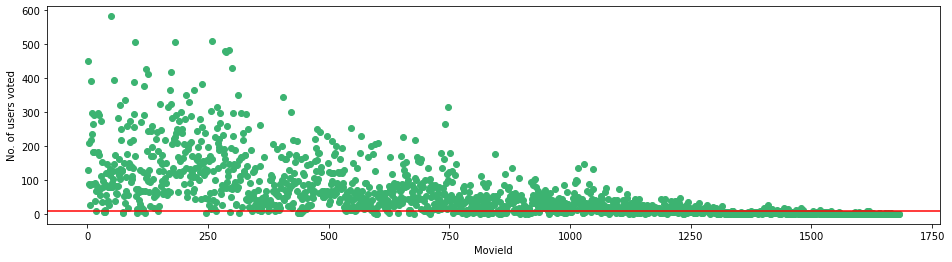

In [0]:
#Let’s visualize the number of users who voted with our threshold of 10.
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [0]:
#Making the necessary modifications as per the threshold set.
df_final = mat.loc[no_user_voted[no_user_voted > 10].index,:]

In [0]:
#Let’s visualize the number of votes by each user with our threshold of 50.
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [0]:
#Making the necessary modifications as per the threshold set.
df_final = mat.loc[:,no_movies_voted[no_movies_voted > 50].index]
df_final

user_id 
 1 
 2 
 3 
 5 
 6 
 7 
 8 
 10 
 11 
 12 
 ... 
 930 
 931 
 932 
 933 
 934 
 936 
 938 
 940 
 942 
 943 
 
 
 movie_id 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 5.0 
 4.0 
 0.0 
 4.0 
 4.0 
 0.0 
 0.0 
 4.0 
 0.0 
 0.0 
 ... 
 3.0 
 0.0 
 4.0 
 3.0 
 2.0 
 4.0 
 4.0 
 0.0 
 0.0 
 0.0 
 
 
 2 
 3.0 
 0.0 
 0.0 
 3.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 4.0 
 0.0 
 0.0 
 0.0 
 0.0 
 5.0 
 
 
 3 
 4.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 4.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 4 
 3.0 
 0.0 
 0.0 
 0.0 
 0.0 
 5.0 
 0.0 
 4.0 
 0.0 
 5.0 
 ... 
 0.0 
 0.0 
 0.0 
 3.0 
 5.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 
 
 5 
 3.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1678 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1679 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1680 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1681 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 1682 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 
 1682 rows × 563 columns

In [0]:
csr_data = csr_matrix(df_final.values)
df_final.reset_index(inplace=True)

In [0]:
#We will be using KNN algorithm to compute similarity with cosine distance metric which is very fast and more preferable than pearson coefficient.
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

Out[20]: NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [0]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 20
    movie_list = df[df['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movie_id']
        movie_idx = df_final[df_final['movie_id'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = df_final.iloc[val[0]]['movie_id']
            idx = df[df['movie_id'] == movie_idx].index
            recommend_frame.append({'Title':df.iloc[idx]['title'].values[0],'Distance':val[1]})
        df_recommend = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df_recommend
    else:
        return "No movies found. Please check your input"

In [0]:
get_movie_recommendation('Kolya')

Title 
 Distance 
 
 
 
 
 1 
 Fly Away Home 
 0.681671 
 
 
 2 
 Raise the Red Lantern 
 0.680329 
 
 
 3 
 Antonia's Line 
 0.679670 
 
 
 4 
 Like Water For Chocolate 
 0.673561 
 
 
 5 
 Angels and Insects 
 0.664926 
 
 
 6 
 L.A. Confidential 
 0.664229 
 
 
 7 
 Mrs. Brown 
 0.652900 
 
 
 8 
 Ulee's Gold 
 0.652874 
 
 
 9 
 Ridicule 
 0.652396 
 
 
 10 
 Lone Star 
 0.647755 
 
 
 11 
 Mighty Aphrodite 
 0.645995 
 
 
 12 
 Big Night 
 0.635106 
 
 
 13 
 Everyone Says I Love You 
 0.634546 
 
 
 14 
 Postino, Il 
 0.633413 
 
 
 15 
 English Patient, The 
 0.628556 
 
 
 16 
 Shall We Dance? 
 0.627580 
 
 
 17 
 Breaking the Waves 
 0.625239 
 
 
 18 
 Ice Storm, The 
 0.618144 
 
 
 19 
 Secrets & Lies 
 0.615062 
 
 
 20 
 Full Monty, The 
 0.613720

In [0]:
df_movie = df.copy()
df_user = df.copy()

In [0]:
#Converting pandas to spark
ratings = spark.createDataFrame(df_movie)

In [0]:
ratings.columns

Out[25]: ['user_id', 'movie_id', 'ratings', 'timestamp', 'title']

In [0]:
ratings.head()

Out[26]: Row(user_id=196, movie_id=242, ratings=3, timestamp=881250949, title='Kolya')

In [0]:
ratings.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- movie_id: long (nullable = true)
 |-- ratings: long (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)



In [0]:
for line in ratings.head(5):
  print(line, '\n')


Row(user_id=196, movie_id=242, ratings=3, timestamp=881250949, title='Kolya') 

Row(user_id=63, movie_id=242, ratings=3, timestamp=875747190, title='Kolya') 

Row(user_id=226, movie_id=242, ratings=5, timestamp=883888671, title='Kolya') 

Row(user_id=154, movie_id=242, ratings=3, timestamp=879138235, title='Kolya') 

Row(user_id=306, movie_id=242, ratings=5, timestamp=876503793, title='Kolya') 



In [0]:
ratings.describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|           user_id|          movie_id|           ratings|         timestamp|             title|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|            100000|            100000|            100000|            100000|            100000|
|   mean|         462.48475|         425.53013|           3.52986| 8.8352885148862E8|          Infinity|
| stddev|266.61442012750865|330.79835632558394|1.1256735991443163|5343856.1895028455|               NaN|
|    min|                 1|                 1|                 1|         874724710|'Til There Was You|
|    max|               943|              1682|                 5|         893286638|    � k�ldum klaka|
+-------+------------------+------------------+------------------+------------------+------------------+



In [0]:
from pyspark.sql.functions import format_number
summary = ratings.describe()
summary.select(summary['summary'],
               format_number(summary['ratings'].cast('float'),2).alias('ratings')
               ).show()

+-------+----------+
|summary|   ratings|
+-------+----------+
|  count|100,000.00|
|   mean|      3.53|
| stddev|      1.13|
|    min|      1.00|
|    max|      5.00|
+-------+----------+



In [0]:
ratings.filter('ratings is Null').count() * ratings.count()
ratings.filter('user_id is Null').count() * ratings.count()
ratings.filter('movie_id is Null').count() * ratings.count()

Out[31]: 0

In [0]:
#Now, we split the data set into training and testing groups and separate the features from the labels for each group.We then use the LinearRegression class to fit the training data set and create predictions for the test data set.
(training, test) = ratings.randomSplit([0.8, 0.2])

In [0]:
#Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="movie_id", ratingCol="ratings",
          coldStartStrategy="drop")
model = als.fit(training)

In [0]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator1 = RegressionEvaluator(metricName="rmse", labelCol="ratings",
                                predictionCol="prediction")
evaluator2 = RegressionEvaluator(metricName="mse", labelCol="ratings",
                                predictionCol="prediction")
evaluator3 = RegressionEvaluator(metricName="mae", labelCol="ratings",
                                predictionCol="prediction")
rmse = evaluator1.evaluate(predictions)
mse= evaluator2.evaluate(predictions)
mae=evaluator3.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
print("Mean-square error = " + str(mse))
print("Mean-absolute error = " + str(mae))

Root-mean-square error = 1.068939565189962
Mean-square error = 1.1426317940285051
Mean-absolute error = 0.814727793564739


In [0]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
movieSubSetRecs.show()

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|     242|[{68, 7.4009104},...|
|     302|[{477, 6.732825},...|
|     377|[{771, 7.0086074}...|
+--------+--------------------+



In [0]:
movielist=userRecs.select('recommendations').where(userRecs.user_id == 6).collect()
movielist

Out[37]: [Row(recommendations=[Row(movie_id=390, rating=6.330094337463379), Row(movie_id=361, rating=5.899064064025879), Row(movie_id=1529, rating=5.6733198165893555), Row(movie_id=1174, rating=5.634762287139893), Row(movie_id=964, rating=5.605865478515625), Row(movie_id=1367, rating=5.604869842529297), Row(movie_id=961, rating=5.574676036834717), Row(movie_id=1394, rating=5.406894683837891), Row(movie_id=1664, rating=5.403560638427734), Row(movie_id=1558, rating=5.390893936157227)])]

In [0]:
schema = StructType([
  StructField('movie_id', IntegerType(), True),
  StructField('title', StringType(), True),
  StructField('ratings', DoubleType(), True)
  ])
Recommended_Movie = spark.createDataFrame([], schema)
for list in movielist[0]['recommendations']:
  Movie=ratings.select("title").distinct().where(ratings.movie_id==list.movie_id).collect()
  ratings_based=ratings.select("ratings").where((ratings.movie_id==list.movie_id) ).collect()
  avg_ratings=0
  for i in ratings_based:
    avg_ratings=avg_ratings+i.ratings
  if(len(Movie)>0):
    newRow = spark.createDataFrame([(list.movie_id,Movie[0].title,avg_ratings/len(ratings_based))])
    Recommended_Movie=Recommended_Movie.union(newRow)

Recommended_Movie.show()

+--------+--------------------+------------------+
|movie_id|               title|           ratings|
+--------+--------------------+------------------+
|     390| Fear of a Black Hat|               3.2|
|     361|           Incognito|               3.5|
|    1529|         Underground|               2.8|
|    1174|              Caught|              3.25|
|     964|Month by the Lake, A|3.3333333333333335|
|    1367|               Faust|               4.2|
|     961|             Orlando|3.6176470588235294|
|    1394|  Swept from the Sea|2.4285714285714284|
|    1664|8 Heads in a Duff...|              3.25|
|    1558|           Aparajito|3.5714285714285716|
+--------+--------------------+------------------+



In [0]:
userlist=movieRecs.select('recommendations').where(movieRecs.movie_id == 17).collect()
userlist

Out[39]: [Row(recommendations=[Row(user_id=202, rating=6.703995227813721), Row(user_id=418, rating=6.437241554260254), Row(user_id=133, rating=6.298574924468994), Row(user_id=310, rating=6.281704902648926), Row(user_id=752, rating=6.170164108276367), Row(user_id=356, rating=6.1041789054870605), Row(user_id=50, rating=6.041993141174316), Row(user_id=248, rating=6.018677711486816), Row(user_id=812, rating=5.951768398284912), Row(user_id=471, rating=5.896010875701904)])]

In [0]:
schema = StructType([
  StructField('user_id', IntegerType(), True),
  StructField('title', StringType(), True),
  StructField('ratings', DoubleType(), True)
  ])
Recommended_user = spark.createDataFrame([], schema)

Movie=ratings.select("title").distinct().where(ratings.movie_id==17).collect()
for list in userlist[0]['recommendations']:
  ratings_based=ratings.select("ratings").where((ratings.user_id==list.user_id) ).collect()
  avg_ratings=0
  for i in ratings_based:
    avg_ratings=avg_ratings+i.ratings
  newRow = spark.createDataFrame([(list.user_id,Movie[0].title,avg_ratings/len(ratings_based))])
  Recommended_user=Recommended_user.union(newRow)

Recommended_user.show()

+-------+-------------------+------------------+
|user_id|              title|           ratings|
+-------+-------------------+------------------+
|    202|From Dusk Till Dawn|               2.8|
|    418|From Dusk Till Dawn|               2.9|
|    133|From Dusk Till Dawn|3.1923076923076925|
|    310|From Dusk Till Dawn| 3.857142857142857|
|    752|From Dusk Till Dawn|3.2054794520547945|
|    356|From Dusk Till Dawn|3.5833333333333335|
|     50|From Dusk Till Dawn|3.5416666666666665|
|    248|From Dusk Till Dawn|3.5714285714285716|
|    812|From Dusk Till Dawn|               3.5|
|    471|From Dusk Till Dawn|3.3870967741935485|
+-------+-------------------+------------------+

